In [240]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import json

from icecream import ic

from pymatching import Matching

import jax
import jax.numpy as jnp

key = jax.random.key(42)

In [241]:
def flatten_qubits(qubits: list[list]) -> list:
    """
    Flattens a nested list of qubits and excludes any hidden qubits
    """
    result = []
    for qubit in qubits:
        if isinstance(qubit, list):  # Check if the current element is a list
            # Recursively flatten the nested list
            result.extend(flatten_qubits(qubit))
        else:
            if qubit is None:
                continue
            result.append(qubit)  # Add non-list elements to the result
    return result

def locate_qubit(data, location):
    def _from_index(qubits: list[list], index: list[int]) -> tuple:
        return qubits[index[0]] if len(index) == 1 else _from_index(qubits[index[0]], index[1:])
    return _from_index(data[location[0]]['loc'], location[1:])

In [242]:
def flatten_list(nested_list: list[list]) -> list:
    result = []
    for elm in nested_list:
        if isinstance(elm, list):
            result.extend(flatten_list(elm))
        else:
            result.append(elm)
    return result

def get_elm(nested_list: list[list], index: list[int]):
    if len(index) == 1:
        return nested_list[index[0]]
    else:
        return get_elm(nested_list[index[0]], index[1:])

In [243]:
deformations = {  # The different Clifford deformations (neglecting the phase)
    'I':   [0, 1, 2, 3], 
    'XZ':  [0, 3, 2, 1],
    'YZ':  [0, 1, 3, 2],
    'XY':  [0, 2, 1, 3], 
    'XYZ': [0, 2, 3, 1],
    'XZY': [0, 3, 1, 2]
}
deformations_inv = {  # The different Clifford deformations (neglecting the phase)
    'I':   [0, 1, 2, 3], 
    'XZ':  [0, 3, 2, 1],
    'YZ':  [0, 1, 3, 2],
    'XY':  [0, 2, 1, 3], 
    'XYZ': [0, 3, 1, 2],
    'XZY': [0, 2, 3, 1]
}

def surface_code_data(distance: int) -> dict:
    d = distance
    data = {
        "Data qubit": {
            "type": "data",
            "qubit": [[{
                "loc": (i,j,0),
                "conn": [
                    {
                        "group": "Type A syndrome qubits",
                        "idxs": [(i,j), (i+1,j+1)]
                    },
                    {
                        "group": "Type A syndrome qubits",
                        "idxs": [(i,j+1), (i+1,j)]
                    },
                    {
                        "group": "Type B syndrome qubits",
                        "idxs": [(i,j), (i+1,j+1)]
                    },
                    {
                        "group": "Type B syndrome qubits",
                        "idxs": [(i,j+1), (i+1,j)]
                    },
                ],
                # "deformation": 'I' # Regular surface code
                # "deformation": 'I' if (j+i)%2 == 0 else 'XZ' # XZZX surface code
                "deformation": [['YZ', 'XZ'], ['I', 'YZ']][i%2][j%2] # C1 surface code
            } for j in range(d)] for i in range(d)],
            "plt_style": {"marker": "o", "ls": '', 'mec': '#000000'},
            "error_color": ['#000000', '#990000', '#009900', '#000099'],
            "pauli_colors": ['#000000', '#E53629', '#2CD23E', '#4149C3'],
            "plt_connect_style": {"marker": ''}
        },
        "Type A syndrome qubits": {
            "type": "synd",
            "pauli": 1, # X
            "qubit": [[{
                    "loc": (i-.5,j-.5,0) if 0<j<d and (i+j)%2 == 1 else None
                } for j in range(d+1)] for i in range(d+1)],
            "plt_style": {"marker": "s", "ls": '', 'mec': '#000000'},
            "state_colors": ['#2B2A33', '#D76C43']
        },
        "Type B syndrome qubits": {
            "type": "synd",
            "pauli": 3, # Z
            "qubit": [[{
                    "loc": (i-.5,j-.5,0) if 0<i<d and (i+j)%2 == 0 else None
                } for j in range(d+1)] for i in range(d+1)],
            "plt_style": {"marker": "D", "ls": '', 'mec': '#000000'},
            "state_colors": ['#2B2A33', '#D76C43']
        },
    }
    return clenup_data(index_data(data))

def index_data(data: dict) -> dict:
    """
    Assignes an index to all the qubits that have a location.
    """
    for group in data:
        match data[group]["type"]:
            case "data":
                idx = 0
                for qubit in flatten_list(data[group]['qubit']):
                    if qubit['loc'] is not None:
                        qubit['index'] = idx
                        idx += 1
            case "synd":
                idx = 0
                for qubit in flatten_list(data[group]['qubit']):
                    if qubit['loc'] is not None:
                        qubit['index'] = idx
                        idx += 1
            case _:
                raise NameError(f"No method for handling group of type: {data[group]["type"]}")
    return data

def clenup_data(data: dict) -> dict:
    """
    Flattens all the nested lists by using the assigned index for each qubit
    """
    clean_data = {}
    for group in data:
        match data[group]["type"]:
            case "data":
                clean_data[group] = data[group].copy()
                clean_data[group]['qubit'] = []
                for qubit in flatten_list(data[group]['qubit']):
                    if qubit.get('index', None) is None:
                        continue
                    qubit_ = qubit.copy()
                    # qubit_.pop('index')
                    qubit_['conn'] = []
                    for connection in qubit['conn']:
                        s1 = get_elm(data[connection['group']]['qubit'], connection['idxs'][0])
                        s1_found = s1.get('index', None) is not None
                        s2 = get_elm(data[connection['group']]['qubit'], connection['idxs'][1])
                        s2_found = s2.get('index', None) is not None
                        idxs = []
                        if s1_found:
                            idxs.append(s1['index'])
                        if s2_found:
                            idxs.append(s2['index'])
                        if len(idxs) > 0:
                            qubit_['conn'].append({
                                "group": connection['group'],
                                "idxs": idxs
                            })
                    clean_data[group]['qubit'].append(qubit_)
            case "synd":
                clean_data[group] = data[group].copy()
                clean_data[group]['qubit'] = []
                for qubit in flatten_list(data[group]['qubit']):
                    if qubit.get('index', None) is None:
                        continue
                    qubit_ = qubit.copy()
                    # qubit_.pop('index')
                    clean_data[group]['qubit'].append(qubit_)
            case _:
                raise NameError(f"No method for handling group of type: {data[group]["type"]}")
    return clean_data

data = surface_code_data(distance=7)
with open("TestData.json", 'w') as file:
    json.dump(data, file, indent=4)

In [244]:
def get_qubit_count(data: dict):
    num_dq = {}
    num_sq = {}
    for group in data:
        match data[group]["type"]:
            case "data":
                num_dq[group] = num_dq.get(group, 0) + len(data[group]['qubit'])
            case "synd":
                num_sq[group] = num_sq.get(group, 0) + len(data[group]['qubit'])
            case _:
                raise NameError(f"No method for handling group of type: {data[group]["type"]}")
    return {'dq': num_dq, 'sq': num_sq}

qubit_counts = get_qubit_count(data)
qubit_counts

{'dq': {'Data qubit': 49},
 'sq': {'Type A syndrome qubits': 24, 'Type B syndrome qubits': 24}}

In [245]:
def parity_check_matrix(data: dict) -> dict[jnp.ndarray]:
    count = get_qubit_count(data)
    H = {name: [[0 for _ in range(sum(count['dq'].values()))] for _ in range(count['sq'][name])] 
         for name, content in data.items() if content["type"] == "synd"}
    d_idx = 0
    for group in data:
        if data[group]["type"] != "data":
            continue
        for qubit_d in data[group]["qubit"]:
            for connection in qubit_d['conn']:
                group_s = connection['group']
                for s_idx in connection['idxs']:
                    H[group_s][s_idx][d_idx] = 1
            d_idx += 1
    return {k: jnp.array(v) for k, v in H.items()}


H = parity_check_matrix(data)
for group, h in H.items():
    print(group)
    print(h)
    print()

Type A syndrome qubits
[[1 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 1]]

Type B syndrome qubits
[[1 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 1]]



In [246]:
code_deformations = [qubit['deformation'] for qubit in data['Data qubit']['qubit']]

def deform_error(errors, code_deformations):
    return jnp.array([deformations[deform][error] for error, deform in zip(errors, code_deformations)])

def deform_error_inv(errors, code_deformations):
    return jnp.array([deformations_inv[deform][error] for error, deform in zip(errors, code_deformations)])

In [247]:
def get_logicals(errors, code_deformations):
    code_distance = jnp.sqrt(qubit_counts['dq']['Data qubit']).astype(int)
    undeformed_errors = deform_error_inv(errors, code_deformations)
    v_err = undeformed_errors[:code_distance]
    h_err = undeformed_errors[::code_distance]
    logical_X = int(jnp.where(jnp.logical_or(v_err == 1, v_err == 2), 1, 0).sum() % 2)
    logical_Z = int(jnp.where(jnp.logical_or(h_err == 2, h_err == 3), 1, 0).sum() % 2)
    ic(logical_X, logical_Z);

In [248]:
subkey, key = jax.random.split(key)
vals = jax.random.randint(key=subkey, shape=sum(qubit_counts['dq'].values()), minval=0, maxval=10)
errors = jnp.where(vals >= 4, 0, vals)
errors_inv_deformed = deform_error_inv(errors, code_deformations)
print(errors)
syndrome_A = jnp.matmul(H['Type A syndrome qubits'], (errors_inv_deformed==2) + (errors_inv_deformed==3)) % 2
print(syndrome_A)
syndrome_B = jnp.matmul(H['Type B syndrome qubits'], (errors_inv_deformed==2) + (errors_inv_deformed==1)) % 2
print(syndrome_B)

syndromes = {
    'Type A syndrome qubits': syndrome_A,
    'Type B syndrome qubits': syndrome_B,
}

[0 2 0 3 2 1 0 0 0 2 3 2 0 0 0 0 0 2 3 0 3 0 1 0 0 0 0 0 0 0 0 0 2 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0]
[1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0]
[1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0]


ic| logical_X: 0, logical_Z: 0


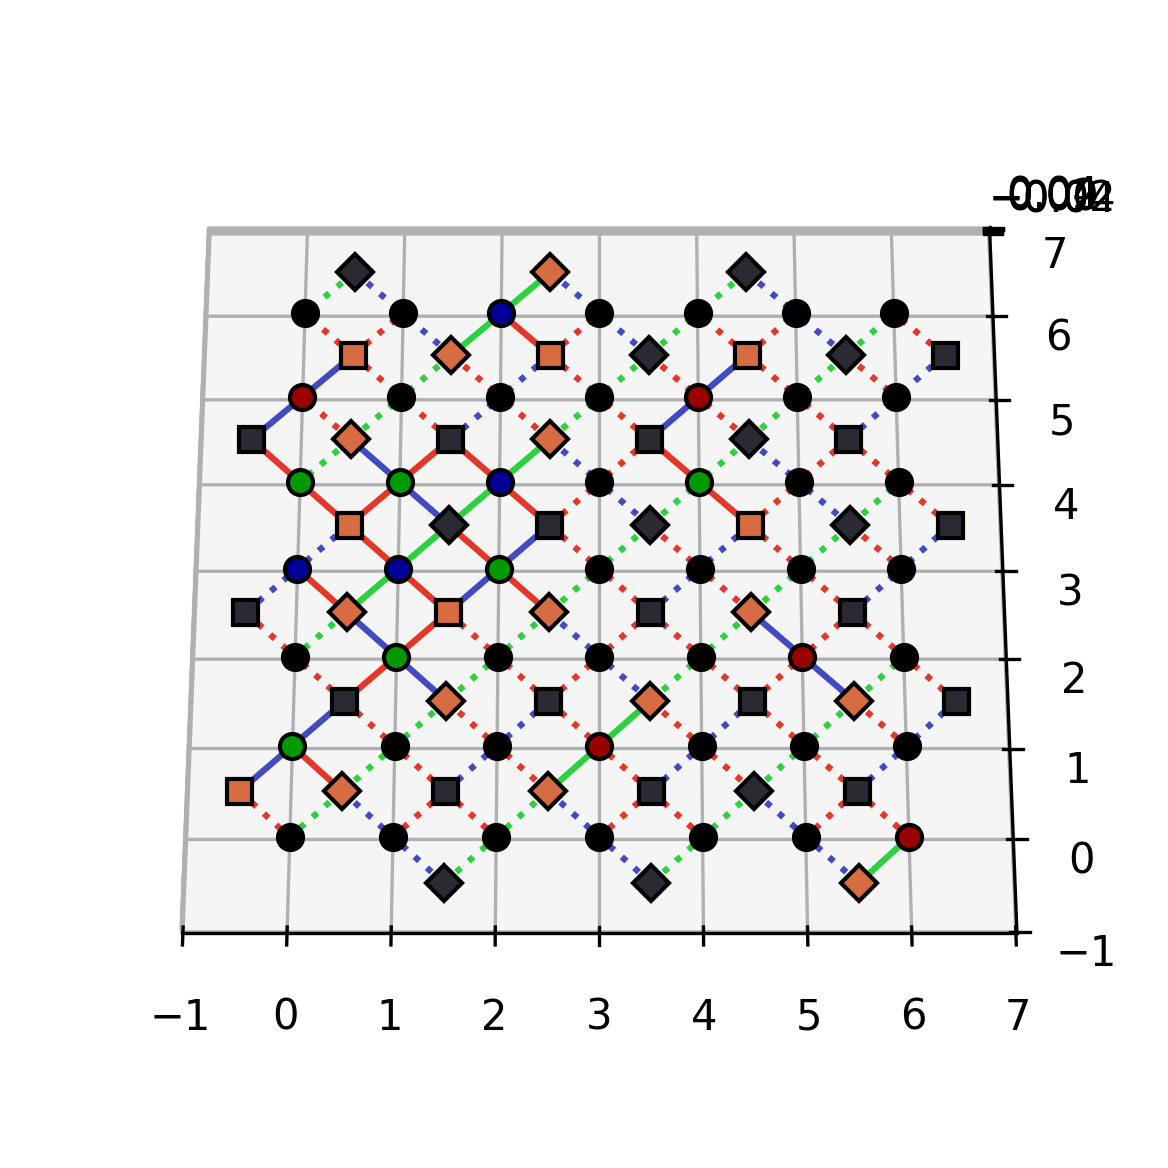

In [249]:

def _plot_data_qubits(data: dict, errors: list[int], group: str, axis: Axes3D):
    for qubit_d, error in zip(data[group]["qubit"], errors):
        axis.plot(
            *qubit_d['loc'], 
            **data[group]["plt_style"], 
            color=data[group]['error_color'][error],
            zorder=3)
        # axis.text(qubit_d['loc'][0], qubit_d['loc'][1]+.2, qubit_d['loc'][2], qubit_d['index'], va='center', ha='center')
        _plot_connections(data, group, qubit_d, error, axis)

def _plot_synd_qubits(data: dict, syndrome: list[int], group: str, axis: Axes3D):
    for qubit_s, synd in zip(data[group]["qubit"], syndrome):
        axis.plot(
            *qubit_s['loc'], 
            **data[group]["plt_style"], 
            color=data[group]["state_colors"][synd],
            zorder=2)
        # axis.text(qubit_s['loc'][0], qubit_s['loc'][1]+.2, qubit_s['loc'][2], qubit_s['index'], va='center', ha='center', color=data[group]["state_colors"][1])

def _plot_connections(data: dict, group: str, qubit_d: dict, error: int, axis: Axes3D):
    for connection in qubit_d['conn']:
        group_s = connection['group']
        group_pauli = data[group_s]['pauli']
        deformation = qubit_d['deformation']
        deformed_pauli = deformations[deformation][group_pauli]
        for idx_s in connection['idxs']:
            qubit_s = data[group_s]['qubit'][idx_s]
            axis.plot(
                *zip(qubit_s['loc'], qubit_d['loc']), 
                color=data[group]["pauli_colors"][deformed_pauli], 
                **data[group]["plt_connect_style"],
                ls = '-' if error != 0 and error != deformed_pauli else ':',
                zorder=1)

def create_legend(axis: Axes3D):
    stab_style = {"marker": "s", "ls": ''}
    A0 = Line2D([0], [0], **stab_style, color='#202020', mec='#000000', label='A stabilizer (not triggered)')
    A1 = Line2D([0], [0], **stab_style, color='#a0a0a0', mec='#000000', label='A stabilizer (triggered)')
    stab_style = {"marker": "D", "ls": ''}
    B0 = Line2D([0], [0], **stab_style, color='#202020', mec='#000000', label='B stabilizer (not triggered)')
    B1 = Line2D([0], [0], **stab_style, color='#a0a0a0', mec='#000000', label='B stabilizer (triggered)')
    axis.legend(handles=[A0, A1, B0, B1], ncol=2)
        
def plot_data(data: dict, errors: list[int], syndromes: dict):
    fig = plt.figure(dpi=300)
    axis: Axes3D = fig.add_subplot(projection='3d')
    for group in data:
        match data[group]["type"]:
            case "data":
                _plot_data_qubits(data, errors, group, axis)
            case "synd":
                _plot_synd_qubits(data, syndromes[group], group, axis)
            case _:
                raise NameError(f"No method for handling group of type: {data[group]["type"]}")
    # create_legend(axis)
    axis.view_init(60, -90, 0)
    axis.set_aspect('equal')

get_logicals(errors, code_deformations)
plot_data(data, errors, syndromes)

ic| logical_X: 0, logical_Z: 1


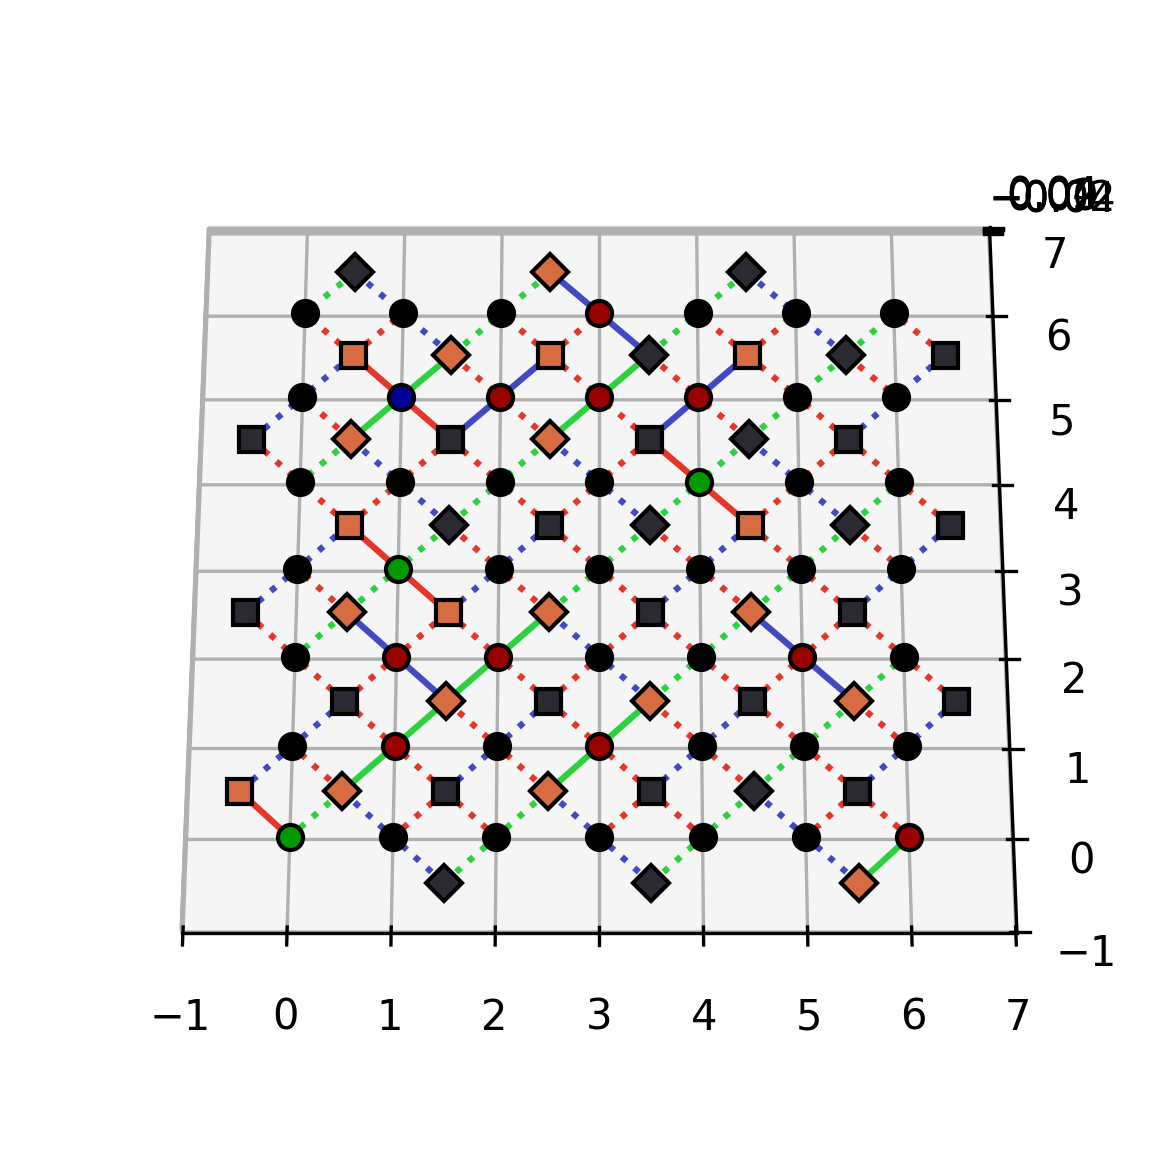

In [250]:
error_probs = [.1, .01, .01]
W_A = [error_probs[deformations[deform][1]-1] for deform in code_deformations]
W_B = [error_probs[deformations[deform][3]-1] for deform in code_deformations]

mwpm_A = Matching(H['Type A syndrome qubits'], weights=W_A)
mwpm_B = Matching(H['Type B syndrome qubits'], weights=W_B)

correction_A = mwpm_A.decode(syndrome_A)
correction_B = mwpm_B.decode(syndrome_B)
correction_deformed = jnp.where(correction_A, jnp.where(correction_B, 2, 3), jnp.where(correction_B, 1, 0))
correction = deform_error(correction_deformed, code_deformations)

get_logicals(correction, code_deformations)
plot_data(data, correction, syndromes)

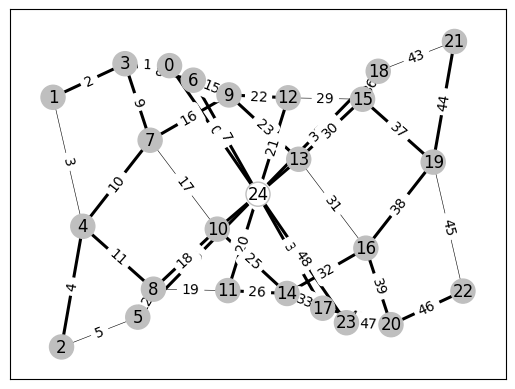

In [251]:
mwpm_A.draw()

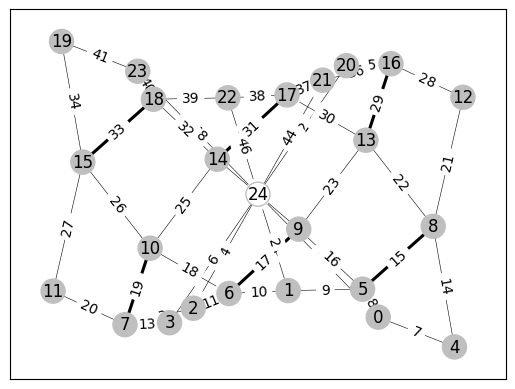

In [252]:
mwpm_B.draw()

ic| logical_X: 0, logical_Z

: 1


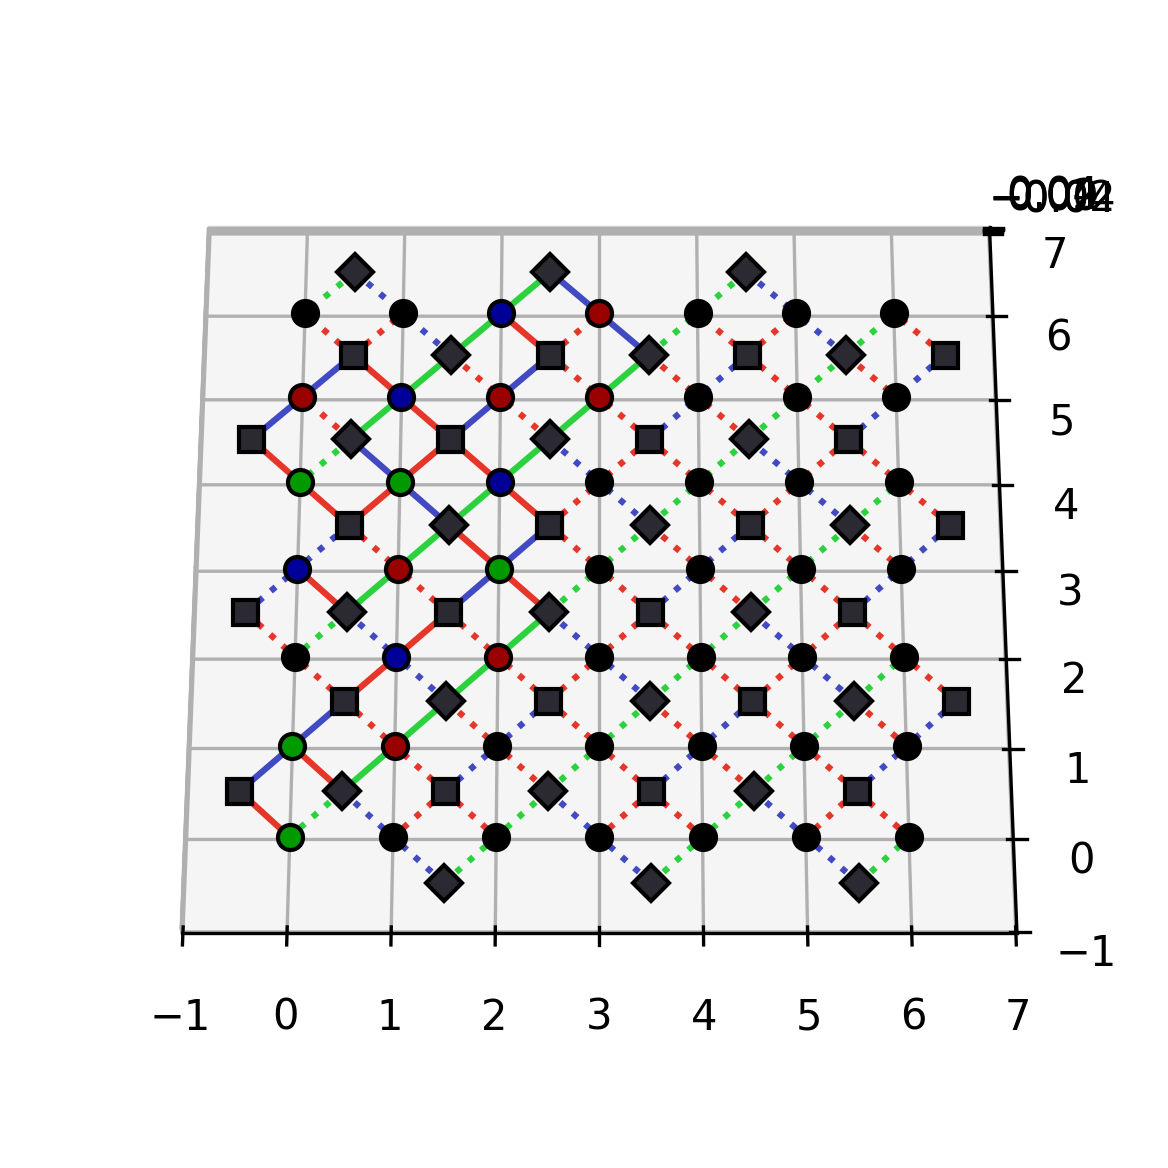

In [254]:
def combine_errors_and_correction(errors, correction):
    merge = jnp.array([
        [0,1,2,3],
        [1,0,3,2],
        [2,3,0,1],
        [3,2,1,0]
    ])
    return jnp.array([merge[e,c] for e,c in zip(errors, correction)])

comb = combine_errors_and_correction(errors, correction)

comb_inv_deformed = deform_error_inv(comb, code_deformations)
syndrome_A_final = jnp.matmul(H['Type A syndrome qubits'], (comb_inv_deformed==2) + (comb_inv_deformed==3)) % 2
syndrome_B_final = jnp.matmul(H['Type B syndrome qubits'], (comb_inv_deformed==2) + (comb_inv_deformed==1)) % 2
syndromes_final = {
    'Type A syndrome qubits': syndrome_A_final,
    'Type B syndrome qubits': syndrome_B_final,
}

get_logicals(comb, code_deformations)
plot_data(data, comb, syndromes_final)